## ENVIROMENT: DEFEND THE CENTER

The map is a **large circle**. A player is spawned in the exact center. 5 melee-only, monsters are spawned along the wall. Monsters are killed after a single shot. After dying, each monster is respawned after some time. The **episode ends when the player dies (it’s inevitable because of limited ammo)**.

<img src="./DEFEND_THE_CENTER.png"/>

configuration File: `defend_the_center.cfg`<br>
**REWARD:**
- +1 for killing a monster
- -1 for death<br>

**AVAILABLE MOVES:**
1. actions[0] : TURN_LEFT `[1 0 0]`
2. actions[1] : TURN_RIGHT `[0 1 0]`
3. actions[2] : ATTACK `[0 0 1]`<br>

**difficulty level:** `doom_skill` = 3<br>
**AMMO:** 26<br>
**HEALTH:** 100%<br>
**SHILD:** 0<br>

In [16]:
from vizdoom import *
import random
import time
import numpy as np
import os

# SETUP-GAME

In [2]:
game = DoomGame()
game.load_config(r'./scenarios/defend_the_center.cfg')
game.init()

In [3]:
actions = np.identity(3, dtype=np.uint8)
print(actions)

[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [7]:
game.new_episode()
game.is_episode_finished()
game.make_action(random.choice(actions))

0.0

In [6]:
episodes = 3
for e in range(episodes):
    game.new_episode()
    while not game.is_episode_finished():
        satate=game.get_state()
        state = game.get_state()
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        reward = game.make_action(random.choice(actions),4) # frame skip=4 time for agent to process
        print('reward:', reward) 
        print("ammo",info)
        print("state",state)
        time.sleep(0.02)
    print('////////////////// Result:', game.get_total_reward())
    time.sleep(2)

reward: 0.0
ammo [ 26. 100.]
state <vizdoom.vizdoom.GameState object at 0x00000122A12294B0>
reward: 0.0
ammo [ 26. 100.]
state <vizdoom.vizdoom.GameState object at 0x00000122A1228430>
reward: 0.0
ammo [ 26. 100.]
state <vizdoom.vizdoom.GameState object at 0x00000122A122B330>
reward: 0.0
ammo [ 26. 100.]
state <vizdoom.vizdoom.GameState object at 0x00000122A12294B0>
reward: 0.0
ammo [ 25. 100.]
state <vizdoom.vizdoom.GameState object at 0x00000122A1228430>
reward: 0.0
ammo [ 25. 100.]
state <vizdoom.vizdoom.GameState object at 0x00000122A122B330>
reward: 0.0
ammo [ 25. 100.]
state <vizdoom.vizdoom.GameState object at 0x00000122A12287B0>
reward: 0.0
ammo [ 25. 100.]
state <vizdoom.vizdoom.GameState object at 0x000001228AE402B0>
reward: 0.0
ammo [ 24. 100.]
state <vizdoom.vizdoom.GameState object at 0x00000122A122B330>
reward: 0.0
ammo [ 24. 100.]
state <vizdoom.vizdoom.GameState object at 0x00000122A12287B0>
reward: 0.0
ammo [ 24. 100.]
state <vizdoom.vizdoom.GameState object at 0x000001

In [8]:
game.close()

## Converting it to a Gymnasium Environment

In [17]:
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from stable_baselines3 import DQN, PPO
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env
from matplotlib import pyplot as plt
import torchvision
import torchaudio
from stable_baselines3.common.callbacks import CheckpointCallback

In [8]:
game = DoomGame()
game.load_config(r'./scenarios/defend_the_center.cfg')
game.init()

In [9]:
game.get_state().screen_buffer

array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[23, 35, 11, ..., 23, 35, 11],
        [23, 11, 35, ..., 11, 35, 35],
        [35, 35, 35, ..., 11, 35, 11],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]]], dtype=uint8)

In [18]:
class VizDoomGym(Env): 
    def __init__(self, render=False): 
        super().__init__()
        self.game = DoomGame()
        self.game.load_config('./scenarios/defend_the_center.cfg')
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)        
        self.game.init()
        
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        
    def step(self, action):
        """
        take action 
        Example of usages:
            game.step(1) # Turn_Left
            game.step(2) # Turn_Right
            game.step(3) # attack
        return:
            state, reward, terminated,truncated, info (AMMO)
        """
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4) 
        terminated = self.game.is_episode_finished()
        truncated = self.game.get_episode_time() >= self.game.get_episode_timeout() 

        state = np.zeros(self.observation_space.shape)  # Default blank state
        info = {"info": 0}  # Default info

        # if self.game.get_state():
        if ~truncated and ~terminated:
            game_state = self.game.get_state()
            if game_state is not None:  
                state = self.grayscale(game_state.screen_buffer)
                info = {"info": game_state.game_variables[0]}

        
        return state, reward, terminated,truncated, info 
    
   
    def render(): 
        pass
    
    def reset(self,seed=None, options=None): 
        """ Restart game """
        # super().reset(seed=seed)
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state),{}

    
    def grayscale(self, observation):
        """ TO Grayscale """
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    def close(self): 
        """ CLOSE """
        self.game.close()

In [21]:
env = VizDoomGym(render=True)
state,_ = env.reset()
print(state)

[[[ 5]
  [10]
  [ 7]
  ...
  [ 4]
  [ 6]
  [10]]

 [[ 3]
  [ 3]
  [ 4]
  ...
  [ 5]
  [ 3]
  [ 7]]

 [[11]
  [ 7]
  [10]
  ...
  [ 9]
  [ 6]
  [ 6]]

 ...

 [[75]
  [63]
  [62]
  ...
  [44]
  [71]
  [60]]

 [[15]
  [48]
  [47]
  ...
  [49]
  [69]
  [47]]

 [[22]
  [14]
  [26]
  ...
  [57]
  [37]
  [39]]]


In [13]:
game.close()

In [14]:
env.reset()

(array([[[ 5],
         [10],
         [ 7],
         ...,
         [ 4],
         [ 6],
         [10]],
 
        [[ 3],
         [ 3],
         [ 4],
         ...,
         [ 5],
         [ 3],
         [ 7]],
 
        [[11],
         [ 7],
         [10],
         ...,
         [ 9],
         [ 6],
         [ 6]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 {})

In [15]:
env_checker.check_env(env)

In [16]:
env.reset()
env.step(1)
env.step(0)
env.step(1)
env.step(2)
env.step(2)

(array([[[ 6],
         [ 9],
         [ 6],
         ...,
         [ 7],
         [11],
         [ 6]],
 
        [[11],
         [ 2],
         [10],
         ...,
         [ 8],
         [ 2],
         [ 9]],
 
        [[ 8],
         [ 9],
         [ 7],
         ...,
         [ 8],
         [10],
         [ 8]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 0.0,
 False,
 False,
 {'info': 25.0})

In [22]:
env.close()

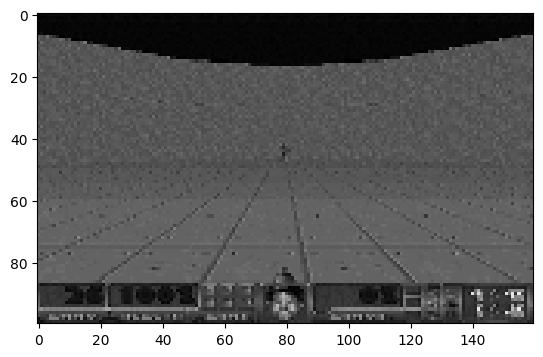

In [18]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

### this is the grayscale image

In [23]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True


In [21]:
CHECKPOINT_DIR = './train/train_Defend_The_Center'
LOG_DIR = './logs/log_Defend_The_Center'

In [25]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [33]:
env=VizDoomGym()

In [34]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001,n_steps=4096)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [35]:
model.learn(total_timesteps=100000, callback=callback)
env.close()

Logging to ./logs/log_Defend_The_Center\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 77.7     |
|    ep_rew_mean     | 0.173    |
| time/              |          |
|    fps             | 30       |
|    iterations      | 1        |
|    time_elapsed    | 135      |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 82          |
|    ep_rew_mean          | 0.384       |
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 2           |
|    time_elapsed         | 290         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010222589 |
|    clip_fraction        | 0.0778      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   

### Testing

In [36]:
model=PPO.load("./train/train_defend_the_center/best_model_90000")

In [37]:
env=VizDoomGym(render=True)

In [38]:
env = Monitor(env)
mean_reward,_=evaluate_policy(model,env,n_eval_episodes=100)

In [39]:
mean_reward

12.38

<b style="color:red">In average the agent is killing 13 player before dying </b> *`penalty for death -1 ==> nb of killed enemy 12+1=13`*

In [40]:
env.close()

In [41]:
import torch
import numpy as np
from stable_baselines3 import DQN, PPO 
import cv2


model_path = "./train/train_defend_the_center/best_model_90000.zip"  
model = PPO.load(model_path)


env = VizDoomGym(render=True)  
num_episodes = 3


for episode in range(num_episodes):
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        time.sleep(0.20)
        total_reward += reward
        done=terminated or truncated
        # time.sleep(1)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    time.sleep(2)
  
# Close environment
env.close()


Episode 1: Total Reward = 8.0
Episode 2: Total Reward = 11.0
Episode 3: Total Reward = 11.0


In [27]:
env.close()

### DQN

In [19]:
env=VizDoomGym()


In [22]:
model = DQN('CnnPolicy',
            env,
            tensorboard_log=LOG_DIR,
            verbose=1,
            buffer_size=5000,
            learning_starts=2000,
            gamma=0.99,
            learning_rate=0.0001,
            batch_size=1024,
            train_freq=8,
            target_update_interval=1000,  
            exploration_initial_eps=1.0,  
            exploration_final_eps=0.05, 
            exploration_fraction=0.1, 
           )


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [46]:
model.learn(total_timesteps=100000, callback=callback)
env.close()

Logging to ./logs/log_Defend_The_Center\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 83.5     |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 12       |
|    time_elapsed     | 26       |
|    total_timesteps  | 334      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.1     |
|    ep_rew_mean      | 0.25     |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 12       |
|    time_elapsed     | 54       |
|    total_timesteps  | 681      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 84.8     |
|    ep_rew_mean      | 0.417    |
|    exploration_rate | 0.903    |
| time/  

KeyboardInterrupt: 

In [24]:
model_path = "./train/train_defend_the_center/best_model_160000.zip"  
model = DQN.load(model_path)
env=VizDoomGym(render=True)
env = Monitor(env)
mean_reward,_=evaluate_policy(model,env,n_eval_episodes=100)

In [25]:
mean_reward

9.58

<b style="color:red">In average the agent is killing 11 player before dying </b> *`penalty for death -1 ==> nb of killed enemy 10+1=11`*

In [4]:
model_path = "./train/train_defend_the_center/best_model_160000.zip"  
model = DQN.load(model_path)


env = VizDoomGym(render=True)  
num_episodes = 3


for episode in range(num_episodes):
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        time.sleep(0.20)
        total_reward += reward
        done=terminated or truncated
        # time.sleep(1)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    time.sleep(2)
  
# Close environment
env.close()


Episode 1: Total Reward = 10.0
Episode 2: Total Reward = 8.0
Episode 3: Total Reward = 11.0


<b style="color:blue">DQN</b> <b>VS</b> <b style="color:pink">PPO</b>
### Episode Length Mean:
<img src="./Screenshot 2025-03-06 215432.png"/><br>
### Episode Reward Mean:
<img src="./Screenshot 2025-03-06 215400.png"/>
